# Data 620 Final Project
# Sentiment Analysis of Health/Personal Care Product Reviews on Amazon
#### Raghunathan Ramnath, Dilip Ganesan and Ahmed Sajjad

## Overview:

   The success and failure of a product sold in amazon can be determined by the customer feedback which helps new customers to gain insight about the product. To minimize the time to read tons of product reviews and at the same time provide the overall summary of reviews, online retailers has to highly rely on recommendation engine.  We would like to analyze on the sentiments associated with specific category “Health and Personal Care” of the products sold in amazon. 

The objective is to 
   
1. Find a classification model that works best with the data.
2. Understanding the topics and words that describe the broad categories of “Health and Personal Care” products sold over Amazon.

## Dataset: 
The dataset of this project is available at Stanford Large Network Dataset Collection site:
    
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz

In [71]:
reset -fs

In [72]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
import gzip
import nltk
import os

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [73]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [74]:
# Code provided via http://jmcauley.ucsd.edu/data/amazon/
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

Convert compressed file of data into Pandas DataFrame

In [75]:

#os.chdir('/Users/dilipganesan/Dilip_Docs/CUNY/DATA620_Web_Analytics/Final Project')
#health_personal = getDF("reviews_Health_and_Personal_Care_5.gz")

#os.chdir('C:\\Users\\sajjaah\\My Documents\\D-Drive\\TRAINING\\07_MS_CUNY_PROGRAM\\COURSES\\DATA_620_WEB_ANALYTICS\\03_ASSIGNMENTS\\Week14_FinalProject')
health_personal = getDF("reviews_Health_and_Personal_Care_5.gz")

In [76]:
print('Dataset size: {:,} words'.format(len(health_personal)))

Dataset size: 346,355 words


In [77]:
health_personal[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"


- **Reformat** datetime  from raw form.

In [78]:
health_personal["reviewTime"] = pd.to_datetime(health_personal["reviewTime"])

- **Rearrange** the left-to-right by relevance

In [79]:
health_personal = health_personal[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [80]:
health_personal.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,159985130X,Handy little gadget,This is a great little gadget to have around. ...,5.0,ALC5GH8CAMAI7,AnnN,"[1, 1]",2011-01-05,1294185600
1,159985130X,Small & may need to encourage battery,I would recommend this for a travel magnifier ...,4.0,AHKSURW85PJUE,"AZ buyer ""AZ buyer""","[1, 1]",2012-02-18,1329523200
2,159985130X,Very good but not great,What I liked was the quality of the lens and t...,4.0,A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""","[75, 77]",2010-06-08,1275955200


## Number of Reviews by Unique Products

In [81]:
products = health_personal['overall'].groupby(health_personal['asin']).count()
print("Number of Unique Products in the Health and Personal Products Category = {}".format(products.count()))

Number of Unique Products in the Health and Personal Products Category = 18534


### Top 20 Most Reviewed Products

In [82]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B0037KMI0U - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B0037KMI0U    1089
B0010JLMO8     767
B001KXZ808     699
B0049LUI9O     528
B000GIPJY8     475
B001F51VRK     469
B000NL0T1G     434
B001F51VS4     431
B004YHKUXC     427
B007UZNS5W     422
B0032TNPOE     422
B001ADL1SG     411
B003X5FYJQ     410
B0026HDURA     376
B0013OQGO6     366
B002PY7P4I     361
B006DR2BEW     345
B0000U1OCI     334
B003WR3QSG     332
B005ACNPKA     323
Name: overall, dtype: int64

Most Reviewed Product, B0037KMI0U - has 1089 reviews.


Product description is:     ** "Tide Original Scent Liquid Laundry Detergent , 50 Fl Oz, 2 Count" **

In [83]:
sorted_products[9267:9268]

asin
B000B688MA    9
Name: overall, dtype: int64

Review of the Middle of overall products is **"LifeSource UA-100 Home Aneroid Blood Pressure Monitor"**

In [84]:
sorted_products[18533]

5

In [85]:
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[18514:], end='\n\n')
print('Several products has least reviews of 5')

Bottom 20 Reviewed Products:

asin
B000HHS6YS    5
B000HHPHK4    5
B000HGMHUI    5
B005OBPI34    5
B001F1DWZS    5
B009XUFAUS    5
B001F51VT8    5
B000HC0OVG    5
B001F2C80C    5
B009YLEL1K    5
B001F3NGRK    5
B005NZ4IBY    5
B000H8DW5K    5
B003B4YO4A    5
B000H84COA    5
B005NWHOPE    5
B009YZD3U6    5
B009Z6KLEK    5
B001F51R9M    5
B000U5ZPJ6    5
Name: overall, dtype: int64

Several products has least reviews of 5


**Most Common Amount of Reviews**

In [86]:
products.mode()

0    5
dtype: int64

## Preprocessing

### Remove punctuations, stopwords, and lemmatize

In [87]:
health_personal['reviewText'][:11]

0     This is a great little gadget to have around. ...
1     I would recommend this for a travel magnifier ...
2     What I liked was the quality of the lens and t...
3     Love the Great point light pocket magnifier!  ...
4     This is very nice. You pull out on the magnifi...
5     The light comes on when the item is pulled.  T...
6     These are lightweight and efficient and have s...
7     We bought one for road trips and trying to int...
8     The screen of the magnifier is small. If you'r...
9     This pocket magnifier is nice and compact.  Th...
10    Seems to be a legit 3X.  I bought my first and...
Name: reviewText, dtype: object

In [88]:
reviews = health_personal['reviewText']
reviews.count()

346355

In [89]:
stops = stopwords.words('english')

In [90]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [91]:
reviews = reviews.apply(lambda x: tokenize(x))
reviews[:11]

0     [This, is, a, great, little, gadget, to, have,...
1     [I, would, recommend, this, for, a, travel, ma...
2     [What, I, liked, wa, the, quality, of, the, le...
3     [Love, the, Great, point, light, pocket, magni...
4     [This, is, very, nice, , You, pull, out, on, t...
5     [The, light, come, on, when, the, item, is, pu...
6     [These, are, lightweight, and, efficient, and,...
7     [We, bought, one, for, road, trip, and, trying...
8     [The, screen, of, the, magnifier, is, small, ,...
9     [This, pocket, magnifier, is, nice, and, compa...
10    [Seems, to, be, a, legit, 3X, , I, bought, my,...
Name: reviewText, dtype: object

## Modeling

Model data

[ 1 ] Classification / Sentiment Analysis ( Logistic Regression, MultinomialNB )

[ 2 ] Clustering / Topic Modeling ( NMF and Lda )


## Classification / Sentiment Analysis (LogReg, Mulitnomial)


In [92]:
cloud = wordcloud.WordCloud(background_color='black', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(health_personal.reviewText))

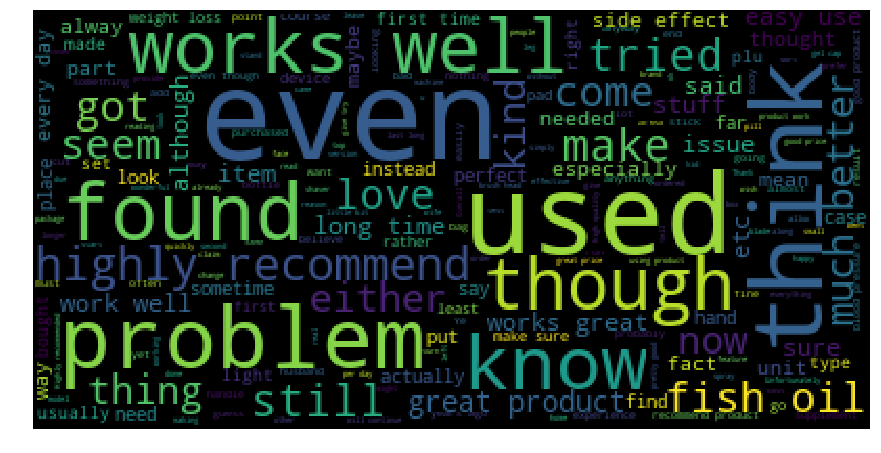

In [93]:
fig = plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(cloud);

In [94]:
health_personal[:3]

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,159985130X,Handy little gadget,This is a great little gadget to have around. ...,5.0,ALC5GH8CAMAI7,AnnN,"[1, 1]",2011-01-05,1294185600
1,159985130X,Small & may need to encourage battery,I would recommend this for a travel magnifier ...,4.0,AHKSURW85PJUE,"AZ buyer ""AZ buyer""","[1, 1]",2012-02-18,1329523200
2,159985130X,Very good but not great,What I liked was the quality of the lens and t...,4.0,A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""","[75, 77]",2010-06-08,1275955200


### Insert pos_neg column for Sentiment modeling

We are going to split the reviews as Positive or Negative depending on the review ratings provided.

Negative reviews:      1-3 Stars  = 0

Positive reviews:      4-5 Stars  = 1

In [95]:
health_personal['pos_neg'] = [1 if x > 3 else 0 for x in health_personal.overall]
health_personal.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg
0,159985130X,Handy little gadget,This is a great little gadget to have around. ...,5.0,ALC5GH8CAMAI7,AnnN,"[1, 1]",2011-01-05,1294185600,1
1,159985130X,Small & may need to encourage battery,I would recommend this for a travel magnifier ...,4.0,AHKSURW85PJUE,"AZ buyer ""AZ buyer""","[1, 1]",2012-02-18,1329523200,1
2,159985130X,Very good but not great,What I liked was the quality of the lens and t...,4.0,A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""","[75, 77]",2010-06-08,1275955200,1


In [96]:
review_text = health_personal["reviewText"]

### Train/Test Split


In [97]:
x_train, x_test, y_train, y_test = train_test_split(health_personal.reviewText, health_personal.pos_neg, random_state=0)

In [98]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (259766,)
y_train shape: (259766,)

x_test shape: (86589,)
y_test shape: (86589,)



We are now going to apply the classification models and compare the accuracy of the three models. 

## Logistic Regression

### CountVectorizer


In [99]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<259766x31990 sparse matrix of type '<class 'numpy.int64'>'
	with 15614418 stored elements in Compressed Sparse Row format>


In [100]:

feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 31990


### Logistic Regression on Training Data

In [101]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.856


In [102]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
X_test = vectorizer.transform(x_test)
log_y_pred = logreg.predict(X_test)

In [103]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


Accuracy:   0.848
Training set score: 0.849
Test set score: 0.848


In [104]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 5368 11183]
 [ 1975 68063]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


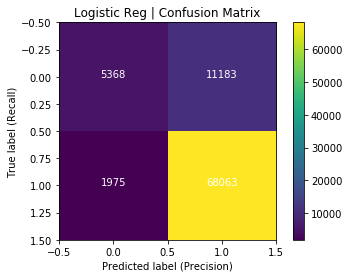

In [105]:
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [106]:
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.912


## Multinomial Naive Bayes 

### CountVectorizer

In [107]:
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [108]:
mnb_y_pred = mnb.predict(X_test)

In [109]:
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score))

print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))

Accuracy:   0.846
Training set score: 0.862
Test set score: 0.846


In [110]:
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 9670  6881]
 [ 6443 63595]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


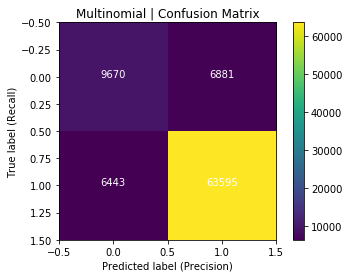

In [111]:

plt.imshow(mnb_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [112]:
mnb_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb_f1))

Multinomial NB - F1 score: 0.905


### TF-IDF Vectorizer

In [113]:
# Vectorize X_train
mnb_tfidfvectorizer = TfidfVectorizer(min_df=5).fit(x_train)
mnb_X_train = mnb_tfidfvectorizer.transform(x_train)
print("X_train:\n{}".format(repr(mnb_X_train)))

X_train:
<259766x31990 sparse matrix of type '<class 'numpy.float64'>'
	with 15614418 stored elements in Compressed Sparse Row format>


In [114]:
mnb_X_test = mnb_tfidfvectorizer.transform(x_test)
mnb_y_pred = mnb.predict(mnb_X_test)

mnb_score2 = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score2))

Accuracy:   0.816


In [115]:
print("Training set score: {:.3f}".format(mnb.score(mnb_X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(mnb_X_test, y_test)))

Training set score: 0.819
Test set score: 0.816


In [116]:
mnb_cfm2 = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm2, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[  691 15860]
 [  105 69933]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


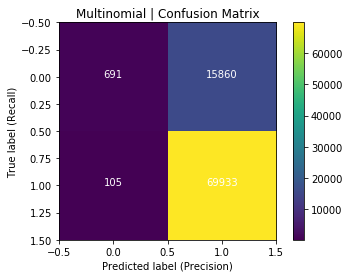

In [117]:

plt.imshow(mnb_cfm2, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm2.shape[0]), range(mnb_cfm2.shape[1])):
    plt.text(j, i, mnb_cfm2[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [118]:
mnb2_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb2_f1))

Multinomial NB - F1 score: 0.898


In [119]:
df = pd.DataFrame(data={
'Model':['LogisticRegression','MultinomialNB-CV','MultinomialNB-TFIDF'],
'TN':[5368,9670,691],
'FP':[11183,6881,15860],
'FN':[1975,6443,105],
'TP':[68063,63595,69933],
'F1 Score ':[0.912,0.905,0.898],
'Accuracy ':[0.848,0.846,0.816]
} )

#### Scores Across Models

In [120]:
df

,Model,TN,FP,FN,TP,F1 Score,Accuracy
0,LogisticRegression,5368,11183,1975,68063,0.912,0.848
1,MultinomialNB-CV,9670,6881,6443,63595,0.905,0.846
2,MultinomialNB-TFIDF,691,15860,105,69933,0.898,0.816


When we compare the Acuracy Scores of Logistic Regression with Naive Bayes, we notice that Logistic Regression using CountVectorizer provides better classification accuracy.

## Topic Modeling (LDA)


### CountVectorizer and NLTK StopWords:


In [121]:
# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 140365


### Build Clustering Models:
#### Latent Dirichlet Allocation (LDA)


In [122]:
# Initialize Ida
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [123]:

num_top_words = 15

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

#### Latent Dirichlet Allocation (LDA) with tf

In more detail, LDA represents documents as mixtures of topics that spit out words with certain probabilities. It assumes that documents are produced in the following fashion: when writing each document, you

- Decide on the number of words N the document will have (say, according to a Poisson distribution).
- Choose a topic mixture for the document (according to a Dirichlet distribution over a fixed set of K topics). For example, assuming that we have the two food and cute animal topics above, you might choose the document to consist of 1/3 food and 2/3 cute animals.
- Generate each word w_i in the document by: 

    - First picking a topic (according to the multinomial distribution that you sampled above; for example, you might pick the food topic with 1/3 probability and the cute animals topic with 2/3 probability).
    
    - Using the topic to generate the word itself (according to the topic’s multinomial distribution). For example, if we selected the food topic, we might generate the word “broccoli” with 30% probability, “bananas” with 15% probability, and so on.

Assuming this generative model for a collection of documents, LDA then tries to backtrack from the documents to find a set of topics that are likely to have generated the collection.

In [ ]:
lda_tf = lda.fit(tf)
lda_ = lda_tf.transform(tf)
Counter([np.argmax(i) for i in lda_])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [ ]:
retrieve_top_words(lda_tf, tfidf_feature_names, num_top_words)

## Summary

Topics LDA are listed above. Topics identifed can be grouped under the below broader category.

- HEALTH CARE
- FITNESS
- PERSONAL CARE
- BEAUTY PRODUCT
- SKIN CARE
- MEDICINE


YouTube Link : https://youtu.be/-3oHfTLC4zY

### References

https://medium.com/@Vishwacorp/nlp-analysis-of-yelp-restaurant-reviews-30b3d0e424a6

https://github.com/xkong100/Data620_Team3/tree/master/final_Project

https://github.com/jeremygrace/amazon-reviews/blob/master/sentiment-topic_modeling/Amazon_Reviews.ipynb

https://www.youtube.com/watch?v=3mHy4OSyRf0

https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df